In [1]:
%load_ext autoreload
%autoreload 2

# Excited states with DANN (PaiNN + diabatization)
This tutorial gives an example of implementing the [equivariant PaiNN architecture](https://arxiv.org/pdf/2102.03150.pdf) for excited states. We'll use the diabatization method that forms the basis of the [DANN model](https://arxiv.org/pdf/2108.04879.pdf).

First we import dependencies for the tutorial:

In [2]:
import sys
from pathlib import Path

# so that NFF is in your path
sys.path.insert(0, "..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate


## Loss function

Let's make a loss function for the model. We'll use three diabatic states, so that the model outputs the six quantities `d_{ij}` for `i >= j`, and `0 <= i, j <= 2`. That means the model outputs `d_00`, `d_01`, etc. The model will then produce three adiabatic energies, `energy_{i}`. Last, the model will also run a backwards pass to produce the gradients `energy_{i}_grad`.

The loss function can penalize errors in the adiabatic energies and forces, adiabatic gaps, and non-adiabatic couplings (NACV). It can also penalize errors in the `d_{i}{i}`, provided that a set of reference geometries with known `d_{i}{i}` is in the dataset. 


The loss function can be created using a dictionary:

In [3]:
loss_dict = {
    "mse": [
        {
            "coef": 0.01,
            "params": {
                "key": "d_00"
            }
        },
        {
            "coef": 0.01,
            "params": {
                "key": "d_11"
            }
        },
        {
            "coef": 0.01,
            "params": {
                "key": "d_22"
            }
        },
        {
            "coef": 0.2,
            "params": {
                "key": "energy_0"
            }
        },
        {
            "coef": 1,
            "params": {
                "key": "energy_0_grad"
            }
        },
        {
            "coef": 0.1,
            "params": {
                "key": "energy_1"
            }
        },
        {
            "coef": 1,
            "params": {
                "key": "energy_1_grad"
            }
        },
        {
            "coef": 0.5,
            "params": {
                "key": "energy_1_energy_0_delta"
            }
        }
    ],
    "nacv": [
        {
            "coef": 1,
            "params": {
                "abs": False,
                "key": "force_nacv_10",
                "max": False
            }
        }
    ]
}

We see that each key is a different type of loss (e.g. `mse` for mean-squared-error), and each value is a list of sub-dictionaries. Each sub-dictionary contains information about the quantities being penalized, through `params`, and their relative weights, through `coef`. For example, `d_11` is through with an MSE loss with weight 0.01. Some notes:

- The NACV gets its own special loss type, called `nacv`. This is because it must correct the phase of the predicted NACV to minimize the prediction error. This accounts for random sign changes in the ground truth NACV.

- Energy gaps in the dataset are denoted `energy_{i}_energy_{j}_delta`, where i > j.  

- Force NACVS in the dataset are denoted `force_nacv_{i}_energy_{j}_delta`, where i > j.  

Now we can supply the loss dictionary to `loss.build_multi_loss`, and we have our loss funnction:

In [4]:
loss_fn = loss.build_multi_loss(loss_dict)



## Making the model

Now let's make the actual model. To do this we can use `get_model`, together with the model parameters and model type. 

Our model type is called `PainnDiabat`, because it's PaiNN with diabatic states. We'll also have to supply the keys below, which include the regular hyperparameters (activation function, feature dimension, etc.), as well as the keys of the diabatic energies. We'll also specify `add_nacv=True`, which means the NACV will get computed when the model is called, and hence can be used in the loss function:


In [5]:
# Only provide the 6 unique diabatic keys
# It doesn't matter whether you use upper- or lower-triangular

diabat_keys = [['d_00', 'd_01', 'd_02'],
               ['d_01', 'd_11', 'd_12'],
               ['d_02', 'd_12', 'd_22']]

modelparams = {
              "feat_dim": 128,
              "activation": "swish",
              "n_rbf": 20,
              "cutoff": 5.0,
              "num_conv": 3,
              "output_keys": ["energy_0",
                             "energy_1"],
              "grad_keys": ["energy_0_grad",
                           "energy_1_grad"],
              "diabat_keys": diabat_keys,
              "add_nacv": True
              }

model = get_model(modelparams, model_type="PainnDiabat")

## Optimizer, metrics, and hooks

Now we create the optimizer, metrics, and hooks, just like we do for regular models. For metrics we'll monitor the energies and forces of each state, as well as the gap:

In [6]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1_grad'),
    metrics.MeanAbsoluteError('energy_1_energy_0_delta')
]


outdir = 'sandbox_excited'
train_hooks = [
    hooks.CSVHook(
        outdir,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        outdir,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        # patience in the original paper
        patience=50,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]




## Dataset

The last thing we have to do before training is load the dataset. For the tutorial we have a pre-baked dataset saved in `data`. So all we have to do is load it, split it, and make data loaders:

In [7]:
dset = Dataset.from_file('data/azo_diabat.pth.tar')
train, val, test = split_train_validation_test(dset, val_size=0.1, test_size=0.1)

batch_size = 20
train_loader = DataLoader(train, 
                          batch_size=batch_size, 
                          collate_fn=collate_dicts,
                          sampler=RandomSampler(train))

val_loader = DataLoader(val, 
                        batch_size=batch_size, 
                        collate_fn=collate_dicts)

test_loader = DataLoader(test, 
                         batch_size=batch_size, 
                         collate_fn=collate_dicts)




## Training

Now we're ready to train!

In [8]:
import shutil

if os.path.isdir(outdir):
    if os.path.isdir('backup'):
        shutil.rmtree('backup')
    shutil.move(outdir, 'backup')
    
T = Trainer(
    model_path=outdir,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1
)

device = 3
T.train(device=device, n_epochs=200)



 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_1 | MAE_energy_0_grad | MAE_energy_1_grad | MAE_energy_1_energy_0_delta | GPU Memory (MB)


  0%|          | 0/40 [00:00<?, ?it/s]../nff/nn/modules/diabat.py:140: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  ad_energies, u = torch.symeig(d_mat, True)
 98%|█████████▊| 39/40 [00:11<00:00,  3.48it/s]


51:34 |     1 |     1.000e-04 |  2717.7992 |       1788.2376 |      18.0294 |      27.0330 |           17.7228 |           17.4251 |                     12.3534 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


51:45 |     2 |     1.000e-04 |  1902.2832 |       1092.2154 |      11.6517 |      13.1026 |           12.8821 |           12.0594 |                      6.2330 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


51:57 |     3 |     1.000e-04 |  1233.8498 |        855.9881 |       9.6267 |      11.2412 |           10.9962 |           10.6404 |                     11.0706 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


52:09 |     4 |     1.000e-04 |   917.4456 |        730.1677 |       7.6774 |      12.1259 |            9.7872 |            9.5677 |                     11.0161 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


52:20 |     5 |     1.000e-04 |   794.1220 |        703.7185 |       6.9821 |      12.6621 |            9.0202 |            9.1541 |                     12.4864 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.52it/s]


52:32 |     6 |     1.000e-04 |   714.5947 |        542.2726 |       7.6109 |       6.4427 |            8.2352 |            7.7042 |                      9.3407 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


52:44 |     7 |     1.000e-04 |   608.5769 |        486.2972 |       6.1892 |       5.9994 |            7.4754 |            6.8743 |                      5.8386 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


52:56 |     8 |     1.000e-04 |   546.2563 |        458.5126 |       5.9609 |       5.0523 |            7.3028 |            6.9480 |                      5.6133 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.60it/s]


53:08 |     9 |     1.000e-04 |   528.2927 |        415.9860 |       6.3522 |       5.0723 |            6.6414 |            5.9789 |                      6.3381 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


53:19 |    10 |     1.000e-04 |   473.3693 |        432.3479 |       5.5405 |       8.2716 |            6.2798 |            5.7677 |                     11.3829 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


53:31 |    11 |     1.000e-04 |   450.2552 |        493.6927 |       8.6668 |       8.9687 |            6.2735 |            5.5927 |                     16.0165 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


53:42 |    12 |     1.000e-04 |   469.1969 |        492.1560 |       7.3545 |       8.2814 |            6.7186 |            6.1185 |                      7.6415 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


53:54 |    13 |     1.000e-04 |   416.5367 |        404.1729 |       9.1896 |       4.4897 |            6.0668 |            5.5470 |                     11.2759 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


54:05 |    14 |     1.000e-04 |   409.6282 |        360.8139 |       4.7759 |       4.5726 |            5.7338 |            5.2077 |                      5.4973 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


54:17 |    15 |     1.000e-04 |   420.0882 |        351.7942 |       5.1004 |       5.1325 |            5.6054 |            4.9990 |                      8.3797 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


54:29 |    16 |     1.000e-04 |   389.7073 |        343.2228 |       4.6360 |       5.0878 |            5.5470 |            5.0345 |                      7.6667 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.63it/s]


54:40 |    17 |     1.000e-04 |   379.7324 |        772.3954 |      13.1635 |      15.6391 |            5.5189 |            5.0466 |                     28.1373 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


54:52 |    18 |     1.000e-04 |   463.8262 |        332.2655 |       5.0124 |       4.0253 |            5.7991 |            5.0174 |                      5.3017 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


55:03 |    19 |     1.000e-04 |   356.0708 |        319.7089 |       8.1831 |       4.0701 |            5.6704 |            4.8728 |                      7.8038 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.60it/s]


55:15 |    20 |     1.000e-04 |   341.3603 |        298.1683 |       4.3071 |       3.3831 |            5.4930 |            4.7689 |                      5.0209 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


55:27 |    21 |     1.000e-04 |   375.8824 |        355.0290 |       9.9052 |       3.6129 |            5.4900 |            4.8320 |                     11.4799 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.63it/s]


55:39 |    22 |     1.000e-04 |   332.3131 |        308.3228 |       6.3621 |       6.8943 |            5.2543 |            4.7734 |                      5.4269 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]


55:51 |    23 |     1.000e-04 |   297.9185 |        247.3574 |       3.4568 |       3.6376 |            5.1539 |            4.6990 |                      4.9079 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


56:02 |    24 |     1.000e-04 |   279.2017 |        232.5982 |       4.6724 |       3.2261 |            4.9053 |            4.5360 |                      4.5100 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


56:14 |    25 |     1.000e-04 |   249.7508 |        265.8773 |       6.6233 |       4.0939 |            4.9489 |            4.6210 |                      8.9506 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.76it/s]


56:25 |    26 |     1.000e-04 |   263.5056 |        288.9350 |       9.6318 |      12.0437 |            5.1871 |            4.7862 |                      4.5748 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


56:37 |    27 |     1.000e-04 |   231.7167 |        217.3473 |       4.5549 |       3.0408 |            4.7424 |            4.4803 |                      5.0811 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


56:48 |    28 |     1.000e-04 |   284.3903 |        230.6379 |      10.6596 |       9.6144 |            4.7700 |            4.4800 |                      3.3499 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


57:00 |    29 |     1.000e-04 |   213.0985 |        368.3929 |      11.0408 |       6.7470 |            4.6453 |            4.3829 |                     16.7722 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.63it/s]


57:11 |    30 |     1.000e-04 |   262.5329 |        245.1701 |       3.6205 |       3.5682 |            5.0147 |            4.7769 |                      3.1295 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


57:23 |    31 |     1.000e-04 |   199.0449 |        199.2475 |       2.7711 |       4.1758 |            4.4766 |            4.3599 |                      5.0754 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


57:35 |    32 |     1.000e-04 |   206.8762 |        187.5800 |       3.1401 |       3.7436 |            4.3627 |            4.2389 |                      5.2903 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


57:46 |    33 |     1.000e-04 |   186.1242 |        178.0450 |       2.5232 |       4.0653 |            4.2750 |            4.1435 |                      4.5873 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


57:58 |    34 |     1.000e-04 |   210.7494 |        251.3960 |       7.4214 |       6.0401 |            4.7252 |            4.6862 |                      3.1017 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


58:09 |    35 |     1.000e-04 |   220.6776 |        199.0871 |       3.2998 |       3.8864 |            4.3795 |            4.2715 |                      5.5039 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.55it/s]


58:21 |    36 |     1.000e-04 |   177.2285 |        168.7415 |       2.1537 |       3.9551 |            4.1264 |            4.0509 |                      3.5831 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.72it/s]


58:32 |    37 |     1.000e-04 |   181.1439 |        178.7133 |       3.2170 |       3.4500 |            4.2714 |            4.2578 |                      2.0378 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


58:44 |    38 |     1.000e-04 |   192.7974 |        193.0649 |       5.1317 |       6.3123 |            4.4548 |            4.1988 |                      2.6064 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.74it/s]


58:55 |    39 |     1.000e-04 |   220.8441 |        201.8746 |       5.8718 |       3.6301 |            4.1958 |            4.1192 |                      7.5032 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


59:07 |    40 |     1.000e-04 |   183.9030 |        227.7560 |       3.5479 |       4.2986 |            4.5425 |            4.3837 |                      6.4690 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


59:18 |    41 |     1.000e-04 |   164.8313 |        146.6905 |       2.5009 |       3.3005 |            3.9301 |            3.8530 |                      1.9076 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


59:29 |    42 |     1.000e-04 |   175.6864 |        200.0333 |       2.5585 |       5.0471 |            4.4227 |            4.2609 |                      4.3214 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.75it/s]


59:41 |    43 |     1.000e-04 |   192.9809 |        150.8118 |       2.2092 |       3.1143 |            3.9893 |            3.9731 |                      2.1108 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


59:52 |    44 |     1.000e-04 |   221.4434 |        184.3113 |       3.2326 |       3.4546 |            4.2472 |            4.1455 |                      3.2306 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


00:04 |    45 |     1.000e-04 |   186.5399 |        156.4319 |       2.4907 |       3.0322 |            3.9648 |            3.9864 |                      2.0397 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


00:15 |    46 |     1.000e-04 |   169.0663 |        195.8119 |       4.9288 |       4.4185 |            4.0486 |            4.0089 |                      8.0171 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.52it/s]


00:27 |    47 |     1.000e-04 |   346.8762 |        272.1366 |       4.4564 |       4.0570 |            5.5101 |            5.2275 |                      4.4949 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


00:39 |    48 |     1.000e-04 |   214.7985 |        163.5406 |       2.6976 |       2.7968 |            4.1506 |            4.2073 |                      2.7822 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


00:50 |    49 |     1.000e-04 |   188.1029 |        163.8135 |       2.2577 |       3.9169 |            4.1406 |            4.0900 |                      3.0149 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


01:02 |    50 |     1.000e-04 |   172.6314 |        225.5431 |       2.4490 |      10.3232 |            4.2473 |            4.1832 |                      9.3014 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


01:14 |    51 |     1.000e-04 |   175.0365 |        169.4064 |       2.3069 |       3.2517 |            4.0962 |            4.0467 |                      3.0511 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


01:25 |    52 |     1.000e-04 |   167.8908 |        232.9805 |       6.6967 |       4.3391 |            4.2014 |            4.2228 |                      9.5542 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


01:37 |    53 |     1.000e-04 |   190.1519 |        161.3401 |       4.3502 |       3.7118 |            4.0259 |            3.9732 |                      2.4255 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


01:48 |    54 |     1.000e-04 |   159.1198 |        132.4867 |       2.3374 |       2.8692 |            3.7138 |            3.7212 |                      1.9252 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


02:00 |    55 |     1.000e-04 |   203.7193 |        209.4290 |       2.2332 |       6.8923 |            4.1524 |            4.1867 |                      7.5393 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


02:12 |    56 |     1.000e-04 |   157.8944 |        147.4400 |       2.3903 |       2.5740 |            3.8726 |            3.8584 |                      2.3074 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


02:23 |    57 |     1.000e-04 |   184.9308 |        157.3975 |       2.4351 |       3.5570 |            3.8634 |            3.9156 |                      4.2161 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


02:34 |    58 |     1.000e-04 |   154.7580 |        255.7301 |       2.6409 |       3.0501 |            4.7397 |            4.7860 |                      3.1872 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


02:46 |    59 |     1.000e-04 |   171.3969 |        164.5876 |       2.5963 |       3.9363 |            3.8622 |            3.8862 |                      5.0180 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


02:57 |    60 |     1.000e-04 |   151.5476 |        159.3652 |       4.3578 |       6.8266 |            3.8069 |            3.8845 |                      2.9353 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.74it/s]


03:09 |    61 |     1.000e-04 |   140.1675 |        151.2094 |       2.0128 |       2.7017 |            3.9006 |            3.7997 |                      2.1227 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.63it/s]


03:20 |    62 |     1.000e-04 |   168.5207 |        191.4114 |       2.3627 |       5.2493 |            4.1691 |            4.0037 |                      6.0159 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


03:32 |    63 |     1.000e-04 |   168.5941 |        141.5797 |       2.1168 |       2.6705 |            3.7836 |            3.7744 |                      2.3916 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


03:43 |    64 |     1.000e-04 |   147.7365 |        152.9104 |       2.1812 |       2.5185 |            3.8148 |            3.8951 |                      2.3033 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


03:55 |    65 |     1.000e-04 |   138.2095 |        139.2295 |       2.0433 |       3.6080 |            3.6980 |            3.6975 |                      2.7696 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


04:06 |    66 |     1.000e-04 |   138.2029 |        157.2930 |       3.2550 |       3.2924 |            3.9212 |            3.7862 |                      1.9818 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


04:17 |    67 |     1.000e-04 |   285.5627 |        164.1583 |       4.1753 |       3.4921 |            4.1984 |            3.9738 |                      1.9984 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


04:29 |    68 |     1.000e-04 |   164.5794 |        182.1768 |       2.1461 |       5.8680 |            3.9406 |            3.9643 |                      5.9387 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


04:40 |    69 |     1.000e-04 |   153.8909 |        170.6801 |       3.9688 |       8.9762 |            3.8708 |            3.8169 |                      5.4148 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


04:52 |    70 |     1.000e-04 |   152.6848 |        205.3920 |       3.0755 |       7.2510 |            3.8772 |            3.8560 |                      9.2739 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.72it/s]


05:03 |    71 |     1.000e-04 |   190.6648 |        173.2793 |       2.1304 |       3.8008 |            3.9750 |            4.1648 |                      3.4941 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


05:15 |    72 |     1.000e-04 |   188.6909 |        150.5728 |       1.9652 |       3.4803 |            3.8617 |            3.7403 |                      3.4881 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


05:26 |    73 |     1.000e-04 |   139.7677 |        160.9335 |       4.8735 |       3.5080 |            3.8760 |            3.8232 |                      3.0547 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.63it/s]


05:38 |    74 |     1.000e-04 |   139.6578 |        182.7122 |       5.9581 |       3.0560 |            3.7989 |            3.8584 |                      7.3051 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


05:49 |    75 |     1.000e-04 |   138.6847 |        111.1681 |       2.1733 |       2.4860 |            3.3979 |            3.3603 |                      1.6307 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


06:01 |    76 |     1.000e-04 |   128.0148 |        154.2057 |       2.2728 |       2.5684 |            3.8113 |            3.7854 |                      2.6143 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


06:12 |    77 |     1.000e-04 |   142.3751 |        129.4365 |       2.5993 |       2.3497 |            3.5680 |            3.5346 |                      2.4029 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.74it/s]


06:24 |    78 |     1.000e-04 |   212.7256 |        210.0969 |       2.8285 |       3.9362 |            4.3432 |            4.2882 |                      4.8959 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


06:35 |    79 |     1.000e-04 |   166.0473 |        164.9494 |       2.9189 |       4.4334 |            3.7669 |            3.7395 |                      6.0761 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.75it/s]


06:46 |    80 |     1.000e-04 |   135.9068 |        120.6486 |       2.7165 |       3.1868 |            3.5264 |            3.4754 |                      1.6570 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.73it/s]


06:57 |    81 |     1.000e-04 |   139.1876 |        156.2585 |       2.2415 |       4.1021 |            3.8288 |            3.8702 |                      2.7428 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


07:08 |    82 |     1.000e-04 |   162.0972 |        130.2364 |       3.0621 |       2.6165 |            3.5546 |            3.5661 |                      2.1689 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


07:20 |    83 |     1.000e-04 |   155.6561 |        145.7182 |       2.1340 |       4.4406 |            3.7795 |            3.6000 |                      3.4122 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


07:31 |    84 |     1.000e-04 |   141.6833 |        147.9757 |       3.9070 |       7.3226 |            3.6141 |            3.5890 |                      3.7385 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.73it/s]


07:43 |    85 |     1.000e-04 |   229.0932 |        315.9306 |       4.6390 |       6.6576 |            5.0075 |            4.5730 |                     10.0887 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


07:54 |    86 |     1.000e-04 |   189.7290 |        166.6409 |       2.3048 |       3.6569 |            3.9102 |            3.9072 |                      4.3465 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


08:06 |    87 |     1.000e-04 |   135.0273 |        125.4758 |       2.3600 |       2.5056 |            3.4869 |            3.4553 |                      1.8482 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


08:17 |    88 |     1.000e-04 |   131.4721 |        139.2911 |       1.8834 |       4.3581 |            3.5708 |            3.5395 |                      3.8543 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


08:29 |    89 |     1.000e-04 |   132.8571 |        146.7539 |       2.0203 |       2.4310 |            3.7154 |            3.7047 |                      1.7996 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


08:40 |    90 |     1.000e-04 |   165.0880 |        122.8530 |       2.4892 |       2.6991 |            3.4871 |            3.3973 |                      1.6695 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.48it/s]


08:52 |    91 |     1.000e-04 |   145.6946 |        154.6039 |       2.7589 |       6.9301 |            3.7090 |            3.5605 |                      4.9912 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]


09:04 |    92 |     1.000e-04 |   122.8996 |        145.5374 |       3.0199 |       2.4085 |            3.6443 |            3.5380 |                      2.8537 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


09:16 |    93 |     1.000e-04 |   125.6054 |        151.5129 |       1.9901 |       2.5094 |            3.7964 |            3.6536 |                      1.7823 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


09:27 |    94 |     1.000e-04 |   164.4462 |        160.9335 |       2.4715 |       3.5831 |            3.8878 |            3.9659 |                      2.6727 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


09:39 |    95 |     1.000e-04 |   148.3751 |        183.8820 |       5.7750 |      12.0096 |            3.7038 |            3.6624 |                      6.5815 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


09:50 |    96 |     1.000e-04 |   138.7953 |        126.0439 |       2.1469 |       2.8674 |            3.5360 |            3.4156 |                      1.6887 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


10:02 |    97 |     1.000e-04 |   158.9042 |        130.3897 |       3.9904 |       5.3496 |            3.4099 |            3.4234 |                      2.0889 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


10:13 |    98 |     1.000e-04 |   143.8732 |        179.5796 |       3.1014 |       3.4482 |            3.9890 |            3.9327 |                      2.1626 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


10:24 |    99 |     1.000e-04 |   126.7851 |        139.9750 |       5.5162 |       7.8054 |            3.5118 |            3.4652 |                      2.8355 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


10:36 |   100 |     1.000e-04 |   141.2354 |        136.1365 |       2.1005 |       2.8957 |            3.6145 |            3.6045 |                      2.3203 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


10:47 |   101 |     1.000e-04 |   136.9124 |        166.5883 |       2.3082 |       2.4241 |            3.9410 |            3.7790 |                      2.1824 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


10:59 |   102 |     1.000e-04 |   140.2766 |        161.0789 |       2.4083 |       3.1473 |            3.8760 |            3.6926 |                      2.1357 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


11:10 |   103 |     1.000e-04 |   115.8795 |        155.8348 |       2.4938 |       2.8471 |            3.7400 |            3.6711 |                      3.7246 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.48it/s]


11:22 |   104 |     1.000e-04 |   110.0661 |        131.6107 |       2.9884 |       3.3196 |            3.5713 |            3.3789 |                      1.6539 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


11:34 |   105 |     1.000e-04 |   179.6823 |        159.4782 |       1.9483 |       2.5963 |            3.8131 |            3.8540 |                      2.2995 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


11:46 |   106 |     1.000e-04 |   126.2343 |        119.3540 |       1.9397 |       3.1012 |            3.3224 |            3.3087 |                      2.2378 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


11:57 |   107 |     1.000e-04 |   121.3571 |        161.6782 |       3.7633 |       2.7235 |            3.7732 |            3.6895 |                      2.9347 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


12:09 |   108 |     1.000e-04 |   209.0379 |        143.1135 |       2.0506 |       2.5084 |            3.5716 |            3.5475 |                      2.1417 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


12:21 |   109 |     1.000e-04 |   127.8609 |        119.1678 |       4.4842 |       4.2031 |            3.4070 |            3.2841 |                      1.7133 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


12:32 |   110 |     1.000e-04 |   120.2527 |        126.9918 |       1.8380 |       3.0466 |            3.4674 |            3.4006 |                      2.9419 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.56it/s]


12:44 |   111 |     1.000e-04 |   109.0016 |        133.3902 |       3.1483 |       3.8232 |            3.5115 |            3.5033 |                      1.6525 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.34it/s]


12:57 |   112 |     1.000e-04 |   211.8765 |        125.6041 |       1.8561 |       2.2278 |            3.4497 |            3.4982 |                      1.7756 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


13:08 |   113 |     1.000e-04 |   122.4165 |        168.4545 |       1.9140 |       2.4202 |            3.8834 |            3.7428 |                      2.1985 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


13:20 |   114 |     1.000e-04 |   134.4344 |        120.3461 |       2.4623 |       3.5220 |            3.3901 |            3.3763 |                      2.0089 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


13:32 |   115 |     1.000e-04 |   126.0028 |        111.1598 |       2.4113 |       2.6732 |            3.2840 |            3.1745 |                      1.5792 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.36it/s]


13:44 |   116 |     1.000e-04 |   168.3002 |        195.4300 |       2.8341 |       4.2645 |            4.1643 |            3.8992 |                      5.5798 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


13:56 |   117 |     1.000e-04 |   130.3370 |        179.8870 |       1.8280 |       2.5117 |            3.9171 |            3.7891 |                      2.1922 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.55it/s]


14:08 |   118 |     1.000e-04 |   230.6919 |        411.2126 |       4.2241 |      16.6192 |            4.7519 |            5.1933 |                     16.1448 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


14:20 |   119 |     1.000e-04 |   312.2777 |        216.4784 |       3.6970 |       5.7808 |            4.1802 |            4.1642 |                      4.7760 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.39it/s]


14:32 |   120 |     1.000e-04 |   165.9846 |        163.0735 |       2.0340 |       4.0364 |            3.7219 |            3.7729 |                      4.0289 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


14:44 |   121 |     1.000e-04 |   132.9715 |        107.0286 |       1.9737 |       3.0875 |            3.1813 |            3.2610 |                      2.0036 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


14:55 |   122 |     1.000e-04 |   112.2206 |        149.3738 |       1.8253 |       3.1604 |            3.6515 |            3.6422 |                      2.8114 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


15:06 |   123 |     1.000e-04 |   122.3620 |        135.7769 |       3.5862 |       6.2684 |            3.3978 |            3.4270 |                      3.3010 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.60it/s]


15:18 |   124 |     1.000e-04 |   119.1296 |        132.9787 |       1.8824 |       2.2388 |            3.5051 |            3.4813 |                      1.7245 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


15:30 |   125 |     1.000e-04 |   157.9416 |        119.7414 |       2.3699 |       2.4376 |            3.3557 |            3.2911 |                      1.6893 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


15:41 |   126 |     1.000e-04 |   103.6758 |        111.9992 |       1.9951 |       2.2422 |            3.2544 |            3.1900 |                      1.3325 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


15:53 |   127 |     1.000e-04 |   135.5377 |        327.6440 |       3.5258 |       4.0958 |            5.0393 |            5.0246 |                      2.9772 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


16:04 |   128 |     1.000e-04 |   139.4413 |        123.6942 |       1.9620 |       3.6821 |            3.3102 |            3.3004 |                      2.5789 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


16:16 |   129 |     1.000e-04 |   108.4399 |        175.2601 |       1.7758 |       2.4602 |            3.7938 |            3.8285 |                      2.1361 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


16:27 |   130 |     1.000e-04 |   138.8474 |        128.1141 |       1.8488 |       2.6089 |            3.4395 |            3.3633 |                      2.4066 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


16:39 |   131 |     1.000e-04 |   125.0953 |        121.3388 |       1.9242 |       2.7019 |            3.3434 |            3.3681 |                      2.3959 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.72it/s]


16:50 |   132 |     1.000e-04 |   120.2895 |        115.6709 |       1.8829 |       2.6579 |            3.2435 |            3.2259 |                      1.7387 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.73it/s]


17:01 |   133 |     1.000e-04 |   327.7253 |        263.8314 |       4.6131 |       3.4990 |            4.8037 |            4.4796 |                      4.7430 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


17:12 |   134 |     1.000e-04 |   199.3217 |        250.5967 |      10.4956 |       2.4393 |            4.0714 |            3.7810 |                     10.6195 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


17:24 |   135 |     1.000e-04 |   186.5917 |        157.2426 |       2.3501 |       6.3745 |            3.7236 |            3.5463 |                      4.7595 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


17:35 |   136 |     1.000e-04 |   135.5553 |        101.9841 |       2.4373 |       2.3828 |            3.2351 |            3.1119 |                      1.5560 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.84it/s]


17:46 |   137 |     1.000e-04 |   125.5337 |        126.9186 |       1.7664 |       3.2375 |            3.4219 |            3.3327 |                      3.2575 |               0


 98%|█████████▊| 39/40 [00:50<00:01,  1.30s/it]


18:38 |   138 |     1.000e-04 |   129.5094 |        124.0224 |       2.4483 |       2.4849 |            3.3696 |            3.2854 |                      3.1829 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


18:50 |   139 |     1.000e-04 |   111.1855 |        115.6598 |       2.8134 |       2.2215 |            3.2199 |            3.1816 |                      2.1276 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


19:01 |   140 |     1.000e-04 |   132.4269 |        124.3037 |       2.0400 |       4.8679 |            3.2870 |            3.2091 |                      3.7460 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.69it/s]


19:13 |   141 |     1.000e-04 |   109.1282 |        122.5451 |       3.1891 |       2.8606 |            3.2264 |            3.2595 |                      2.2251 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


19:24 |   142 |     1.000e-04 |   102.8151 |        113.8985 |       2.6543 |       2.0687 |            3.1945 |            3.1518 |                      2.1781 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


19:36 |   143 |     1.000e-04 |   108.4838 |        117.7937 |       1.8734 |       2.4441 |            3.2395 |            3.2004 |                      1.5398 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.79it/s]


19:47 |   144 |     1.000e-04 |   103.5434 |        115.6489 |       1.9564 |       3.3051 |            3.2142 |            3.1909 |                      2.2548 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.52it/s]


19:59 |   145 |     1.000e-04 |   101.0447 |        137.3180 |       3.0783 |       2.1929 |            3.4472 |            3.3580 |                      2.3481 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


20:10 |   146 |     1.000e-04 |   106.3157 |        141.2588 |       4.1141 |       4.0283 |            3.4503 |            3.3378 |                      1.7596 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


20:22 |   147 |     1.000e-04 |    93.6582 |        102.7337 |       1.7126 |       2.4155 |            3.0539 |            3.0047 |                      1.7903 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


20:33 |   148 |     1.000e-04 |   103.1174 |        140.1030 |       2.1435 |       4.2681 |            3.4452 |            3.3366 |                      3.2899 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


20:45 |   149 |     1.000e-04 |   114.7754 |        100.8113 |       1.8527 |       2.3227 |            3.0521 |            2.9575 |                      1.5541 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.70it/s]


20:56 |   150 |     1.000e-04 |   121.0093 |        126.6296 |       1.9893 |       3.0055 |            3.3655 |            3.2399 |                      2.2965 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


21:08 |   151 |     1.000e-04 |   107.3912 |        110.2288 |       1.8460 |       2.7360 |            3.1463 |            3.1164 |                      1.8714 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


21:20 |   152 |     1.000e-04 |   100.7228 |        118.1607 |       2.2501 |       2.6229 |            3.2415 |            3.1467 |                      1.6302 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


21:31 |   153 |     1.000e-04 |    85.9152 |        110.2960 |       1.9149 |       2.0498 |            3.1502 |            3.1114 |                      1.7116 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


21:43 |   154 |     1.000e-04 |   204.6397 |        167.4791 |       2.2319 |       4.0786 |            3.7122 |            3.6952 |                      4.8470 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.71it/s]


21:54 |   155 |     1.000e-04 |   175.9325 |        258.8811 |       3.4495 |       4.6091 |            4.4711 |            4.2524 |                      7.1320 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.54it/s]


22:06 |   156 |     1.000e-04 |   156.7279 |        156.6544 |       2.3416 |       3.8053 |            3.5060 |            3.6050 |                      2.5873 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


22:18 |   157 |     1.000e-04 |   100.8204 |        123.7170 |       1.7708 |       2.2002 |            3.2409 |            3.2453 |                      1.6488 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.49it/s]


22:30 |   158 |     1.000e-04 |    85.9020 |        104.4742 |       2.0768 |       2.8767 |            3.0135 |            2.9939 |                      1.6100 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.60it/s]


22:42 |   159 |     1.000e-04 |    90.8565 |        140.7191 |       2.0547 |       5.4184 |            3.3134 |            3.3314 |                      4.2413 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.45it/s]


22:54 |   160 |     1.000e-04 |    96.9961 |        112.2070 |       1.6310 |       2.3530 |            3.0946 |            3.0513 |                      2.0325 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.40it/s]


23:06 |   161 |     1.000e-04 |   131.3130 |        160.8123 |       1.8633 |       3.4946 |            3.5189 |            3.4219 |                      4.3562 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


23:18 |   162 |     1.000e-04 |   110.9437 |         99.3121 |       1.7683 |       2.4581 |            2.9472 |            2.9479 |                      1.7400 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


23:29 |   163 |     1.000e-04 |   102.7225 |        238.7401 |       2.5069 |       2.8003 |            4.2207 |            4.1201 |                      2.5410 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


23:41 |   164 |     1.000e-04 |   114.8207 |        138.2047 |       2.1382 |       2.4268 |            3.3714 |            3.3244 |                      1.8028 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.56it/s]


23:53 |   165 |     1.000e-04 |    82.9791 |        101.8051 |       2.3757 |       3.4075 |            2.9451 |            2.9560 |                      1.6104 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]


24:05 |   166 |     1.000e-04 |   104.5007 |        120.3387 |       1.9682 |       4.0991 |            3.1241 |            3.1459 |                      3.0235 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.55it/s]


24:17 |   167 |     1.000e-04 |    87.8577 |         94.0547 |       1.5501 |       1.7972 |            2.8738 |            2.8465 |                      1.3759 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.68it/s]


24:28 |   168 |     1.000e-04 |   107.5780 |        151.0566 |       1.5527 |       5.9904 |            3.2894 |            3.2609 |                      6.1368 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


24:40 |   169 |     1.000e-04 |   119.0884 |        358.0538 |       2.0357 |       2.8610 |            5.1740 |            5.1389 |                      3.5875 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


24:52 |   170 |     1.000e-04 |   195.1907 |        121.4876 |       1.7847 |       1.9069 |            3.2140 |            3.2706 |                      1.8317 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


25:03 |   171 |     1.000e-04 |   104.6717 |        100.4879 |       1.6090 |       1.9566 |            2.9751 |            2.9640 |                      1.4163 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.72it/s]


25:14 |   172 |     1.000e-04 |    74.4027 |         98.5212 |       2.0445 |       1.8659 |            2.8895 |            2.8899 |                      1.5960 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.50it/s]


25:26 |   173 |     1.000e-04 |   116.3167 |         95.1235 |       2.3921 |       2.8721 |            2.8682 |            2.8302 |                      1.3755 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


25:38 |   174 |     1.000e-04 |   101.0509 |        109.8386 |       1.6692 |       1.8857 |            3.0535 |            2.9693 |                      1.6715 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


25:50 |   175 |     1.000e-04 |    79.4608 |        110.8316 |       2.4366 |       3.4886 |            2.9721 |            3.0096 |                      1.8024 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]


26:02 |   176 |     1.000e-04 |    81.6081 |         84.6666 |       1.8924 |       1.9835 |            2.7688 |            2.7486 |                      1.3232 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


26:13 |   177 |     1.000e-04 |   112.1341 |        395.9218 |       5.8317 |       8.3179 |            5.1265 |            4.1276 |                     13.7861 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.49it/s]


26:25 |   178 |     1.000e-04 |   199.9963 |        140.8801 |       1.6311 |       2.1717 |            3.3261 |            3.3513 |                      2.4893 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


26:37 |   179 |     1.000e-04 |    95.2510 |        116.2046 |       2.4027 |       1.8059 |            3.0828 |            3.0794 |                      2.1772 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


26:49 |   180 |     1.000e-04 |   109.4975 |        133.8711 |       2.3539 |       1.7043 |            3.3368 |            3.1485 |                      2.4132 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.44it/s]


27:01 |   181 |     1.000e-04 |   125.0590 |        147.9132 |       2.2580 |       4.5575 |            3.3318 |            3.2685 |                      6.0430 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.64it/s]


27:13 |   182 |     1.000e-04 |    97.0727 |        114.3020 |       3.3902 |       3.1361 |            3.0010 |            3.0160 |                      1.6637 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.46it/s]


27:25 |   183 |     1.000e-04 |   100.4384 |        108.3434 |       2.7387 |       3.5175 |            2.9626 |            2.9322 |                      1.6773 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.46it/s]


27:37 |   184 |     1.000e-04 |    85.0969 |        137.9035 |       1.3954 |       2.0263 |            3.2003 |            3.3001 |                      1.9816 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


27:49 |   185 |     1.000e-04 |   128.7743 |        365.3591 |       3.2479 |       5.9623 |            5.2083 |            5.1008 |                      8.3101 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.61it/s]


28:01 |   186 |     1.000e-04 |   210.6799 |        114.2112 |       1.5937 |       2.3937 |            3.1493 |            3.1691 |                      1.8847 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


28:12 |   187 |     1.000e-04 |   116.0274 |        173.0430 |       2.7020 |       4.5060 |            3.3743 |            3.3842 |                      6.6096 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


28:24 |   188 |     1.000e-04 |   109.8466 |         87.1462 |       2.8259 |       2.9245 |            2.7853 |            2.7530 |                      1.3545 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.67it/s]


28:36 |   189 |     1.000e-04 |    81.9040 |        103.2591 |       1.3875 |       2.0683 |            2.8933 |            2.9214 |                      1.8929 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


28:47 |   190 |     1.000e-04 |    80.1373 |        130.6052 |       1.7266 |       1.9026 |            3.1865 |            3.1191 |                      1.5328 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.65it/s]


28:59 |   191 |     1.000e-04 |   132.6212 |        156.1375 |       1.9289 |       2.5632 |            3.6581 |            3.6839 |                      2.9439 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


29:11 |   192 |     1.000e-04 |   104.3290 |        135.5893 |       2.1721 |       3.1357 |            3.2753 |            3.2465 |                      1.9359 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.51it/s]


29:23 |   193 |     1.000e-04 |    86.8695 |         98.5100 |       2.6827 |       2.3668 |            2.8620 |            2.8301 |                      1.6704 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


29:35 |   194 |     1.000e-04 |   109.4914 |        121.5201 |       1.5437 |       1.8657 |            3.1988 |            3.0425 |                      1.6678 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.55it/s]


29:46 |   195 |     1.000e-04 |    84.3871 |        110.7208 |       1.4895 |       1.6791 |            2.9639 |            2.9427 |                      1.4117 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.59it/s]


29:58 |   196 |     1.000e-04 |    92.8606 |         98.2265 |       1.4922 |       2.0892 |            2.8589 |            2.8831 |                      1.6433 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.56it/s]


30:10 |   197 |     1.000e-04 |    78.1962 |         74.5333 |       1.5764 |       1.7206 |            2.5629 |            2.5524 |                      1.2641 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]


30:22 |   198 |     1.000e-04 |    76.1880 |         80.3558 |       2.3551 |       2.2363 |            2.6420 |            2.6290 |                      1.4221 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.62it/s]


30:34 |   199 |     1.000e-04 |    76.0463 |         83.7252 |       1.3054 |       1.7014 |            2.6601 |            2.6621 |                      1.3158 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.57it/s]


30:45 |   200 |     1.000e-04 |    81.6044 |         92.0815 |       1.2665 |       1.6789 |            2.7448 |            2.7287 |                      1.6780 |               0


## Evaluating

Lastly we'll evaluate the model on the test set. We'll also have to take special care of predicted and target NACVs by correcting the predicted NACV signs.

100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


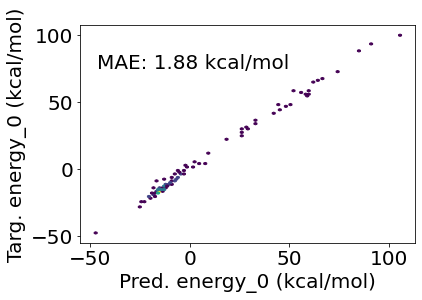

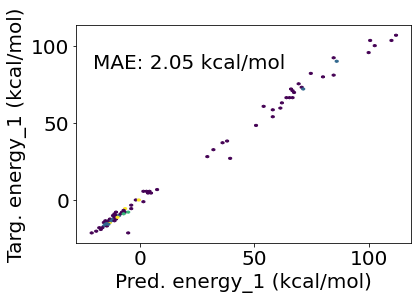

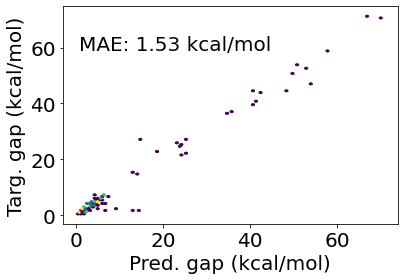

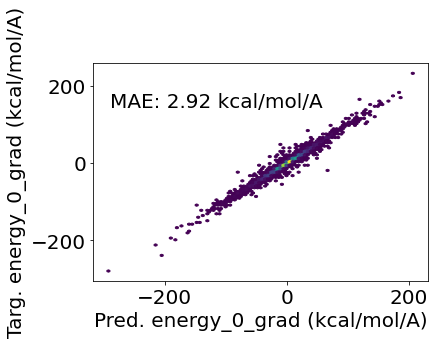

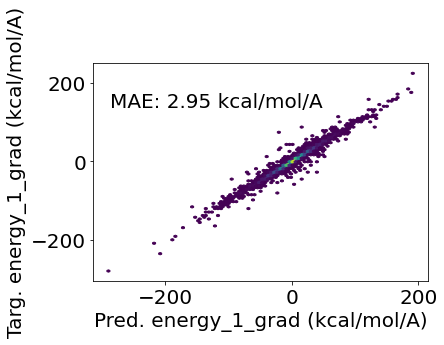

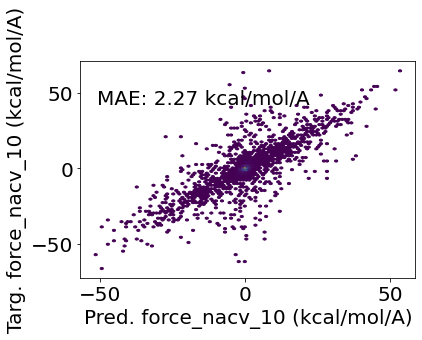

In [12]:
def correct_nacv(results, 
                 targets,
                 key):
    num_atoms = targets['num_atoms']
    if not isinstance(num_atoms, list):
        num_atoms = num_atoms.tolist()
    pred = torch.split(torch.cat(results[key]), num_atoms)
    targ = torch.split(torch.cat(targets[key]), num_atoms)
    
    real_pred = []

    for p, t in zip(pred, targ):
        sub_err = (p - t).abs().mean()
        add_err = (p + t).abs().mean()
        sign = 1 if sub_err < add_err else -1
        real_pred.append(sign * p)
    
    return real_pred
    

def plot(results,
         targets, 
         key,
         units,
         name):
    
    pred = results[key]
    targ = targets[key]
    
    targ_dim = len(targets['energy_0'][0].shape)
    fn = torch.stack if targ_dim == 0 else torch.cat
    pred = torch.cat(pred).reshape(-1)
    targ = fn(targ).reshape(-1)
    
    
    mae = abs(pred - targ).mean()
    text = f"MAE: %.2f {units[key]}" % (mae)
    
    fig, ax = plt.subplots()
    plt.hexbin(pred,
              targ,
              mincnt=1)
    
    
    plt.xlabel(f"Pred. {name} ({units[key]})", fontsize=20)
    plt.ylabel(f"Targ. {name} ({units[key]})", fontsize=20)
    plt.text(0.05, 0.8, text, transform=ax.transAxes,
            fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.locator_params(axis='x', nbins=4) 
    plt.locator_params(axis='y', nbins=4) 
    
    plt.show()
    


results, targets, test_loss = evaluate(T.get_best_model(),
                                       test_loader, 
                                       loss_fn=lambda x, y: torch.Tensor([0]), 
                                       device=device)
real_nacv = correct_nacv(results, targets, 'force_nacv_10')
results['force_nacv_10'] = real_nacv


en_keys = ['energy_0', 'energy_1', 'energy_1_energy_0_delta']
grad_keys = ['energy_0_grad', 'energy_1_grad']

units = {key: 'kcal/mol' for key in en_keys}
units.update({key: 'kcal/mol/A' for key in 
              [*grad_keys, 'force_nacv_10']})

key_dic = {'energy_1_energy_0_delta': 'gap'}

for key in [*en_keys, *grad_keys, 'force_nacv_10']:
    name = key_dic.get(key, key)
    plot(results, 
         targets, 
         key,
         units,
         name=name)




The model is off to a good start!